# Figure 12 --- Multi-player experiment

In [37]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from Config.config import PATHS
from Utils.indices import AlternationIndex
from Utils.utils import GetMeasurements, Grid
from Utils.plot_utils import PlotsAndMeasures, BarRenderer

In [47]:
file_name = 'multi-player.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['source'] = 'humans'
def closest_bin(x):
    bins = np.array([0, 0.25, 0.5, 0.75, 1])
    closest_index = np.argmin(np.abs(bins - x))
    closest_value = bins[closest_index]
    return closest_value

data['real_threshold'] = data['threshold']
data['threshold'] = data['approx_threshold'].apply(lambda x: closest_bin(x))
data.drop(columns=['approx_threshold', 'room', 'date', 'timeup', 'time', 'Unnamed: 0'], inplace=True)

data.head(2)

Loading data from /Users/edgar/Repositorios/Cognitive_Models_El_Farol_Bar_Problem/data/human/multi-player.csv...


,treatment,threshold,round,player,decision,score,num_players,group,choice,source,real_threshold
0,downwards,0.75,1.0,589037721408239,1.0,1.0,8,7,1.0,humans,0.875
1,downwards,0.75,1.0,586994455133371,1.0,1.0,8,7,1.0,humans,0.875


### Playout examples

ValueError: Grouper and axis must be same length

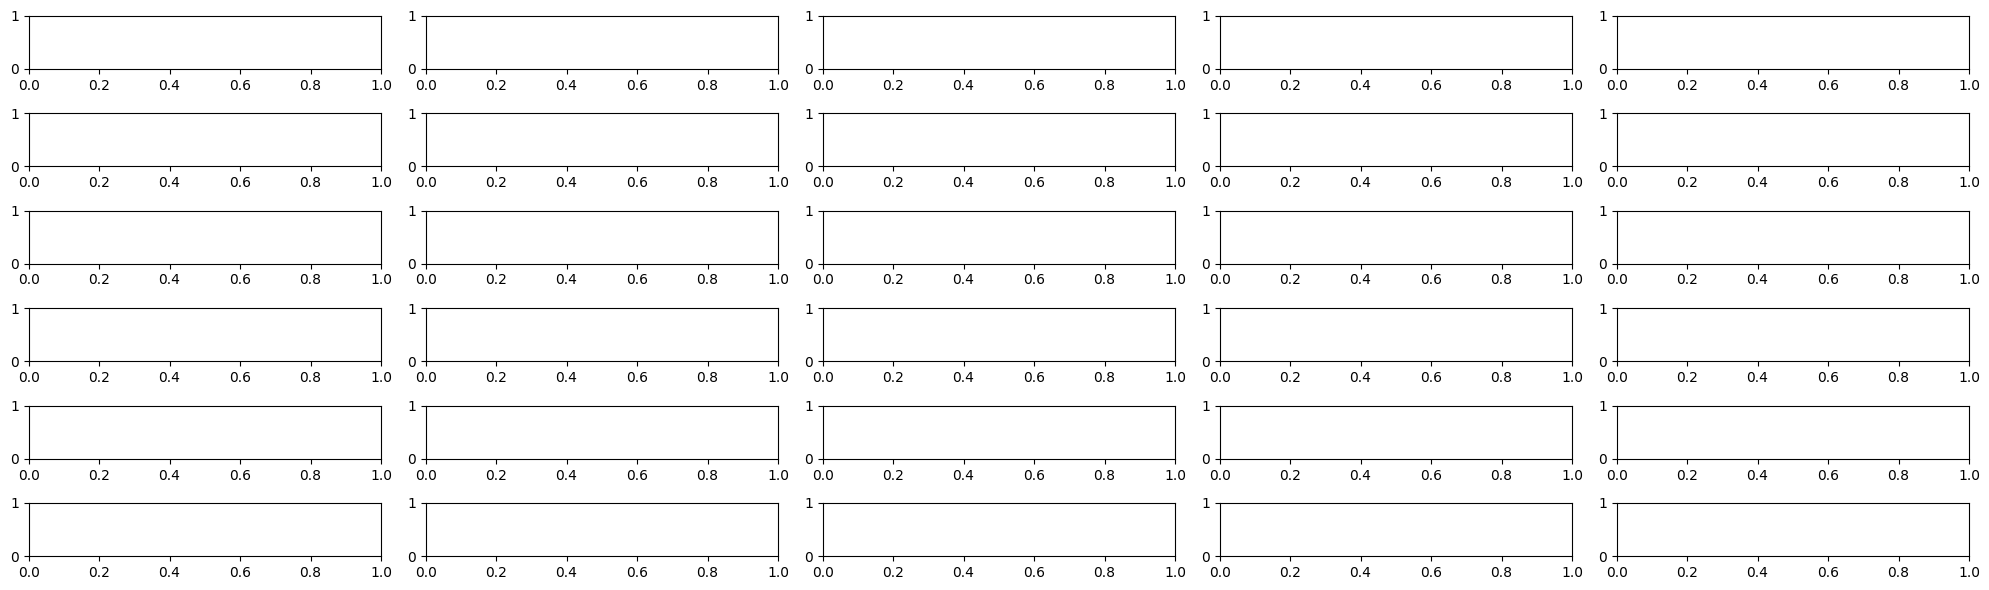

In [65]:
#-------------------------------
# Select groups
#-------------------------------
groups = data['group'].unique().tolist()
#-------------------------------
# Plot groups
#-------------------------------
grid = Grid(len(groups))
fig, axes = plt.subplots(
    grid.rows, grid.cols, 
    figsize=(grid.cols*4, grid.rows),
    tight_layout=True
)
data_gt3 = data[data['num_players'] != 3]
for (group, threshold), grp in data_gt3.groupby([['group', 'threshold']]):
    bar_renderer = BarRenderer(data=grp)
    bar_renderer.render(
        ax=axes[grid.index_to_pair(i)], 
        title=f"Group ({group}) - $\mu=${threshold}",
        # title=f"Group ({i+1})",
        num_rounds=30
    )

### Average score per round

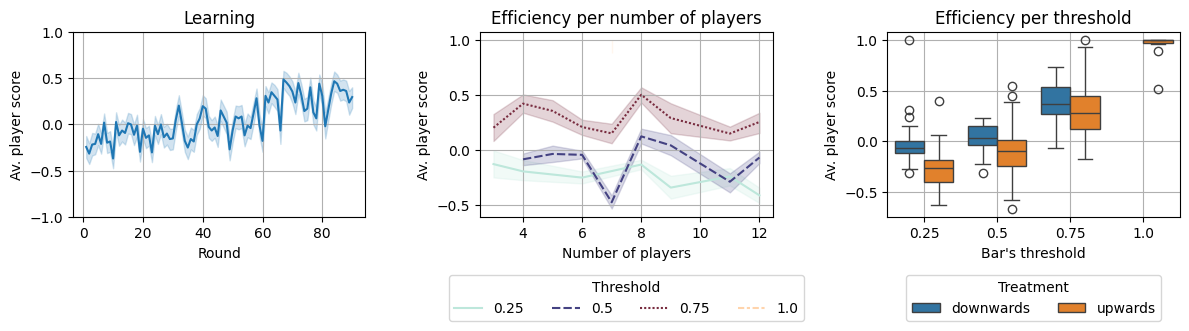

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(12,3), tight_layout=True)

# Learning: average score increases per round
sns.lineplot(
    x='round', y='score', data=data,
    ci=95, ax=ax[0]
)
ax[0].set_xlabel('Round')
ax[0].set_ylabel("Av. player score")
ax[0].set_title("Learning")
ax[0].grid()
ax[0].set_ylim([-1,1])

# Efficiency per number of players
av_scores = data.groupby(['num_players', 'approx_threshold', 'player']).agg({
    'score':'mean',
    'decision':'mean'
})
sns.lineplot(
    x='num_players', y='score',
    hue='approx_threshold', style='approx_threshold',
    data=av_scores, ax=ax[1],
    palette='icefire'
)
ax[1].set_xlabel("Number of players")
ax[1].set_ylabel("Av. player score")
ax[1].set_title("Efficiency per number of players")
ax[1].grid()
# ax[1].set_ylim([-1,1])
ax[1].legend(
    title='Threshold',
    loc='lower center', 
    bbox_to_anchor=(0.5, -.6),
    ncol=4
)

# Efficiency per treatment
av_scores = data.groupby(['treatment', 'approx_threshold', 'player']).agg({
    'score':'mean',
    'decision':'mean'
})
sns.boxplot(
    x='approx_threshold', y='score',
    hue='treatment',
    data=av_scores, ax=ax[2]
)
ax[2].set_xlabel("Bar's threshold")
ax[2].set_ylabel("Av. player score")
ax[2].set_title("Efficiency per threshold")
ax[2].grid()
# ax[2].set_ylim([-1,1])
ax[2].legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -.6),
    ncol=2
)


fig.savefig(PATHS['bar_images'] / 'learning_mult.png', dpi=300, bbox_inches='tight')

### Distribution of alternation index

In [ ]:
# Calculate alternation index per group
data['model'] = data.apply(lambda x: f"{x['room']} --- {x['approx_threshold']}", axis=1)
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'normalized_efficiency', 'inequality']
)
df = gm.get_measurements()

alt_index = AlternationIndex.from_file(priority='sklearn')

df['alternation index'] = alt_index(df)
df.head(2)

,model,treatment,threshold,room,num_players,efficiency,normalized_efficiency,inequality,approx_threshold,alternation index
0,11 --- 0.25,downwards,0.375,11,8,-0.059524,-0.158730,0.075292,0.25,0.175107
1,11 --- 0.5,downwards,0.625,11,8,0.113095,0.180952,0.154696,0.50,0.234762


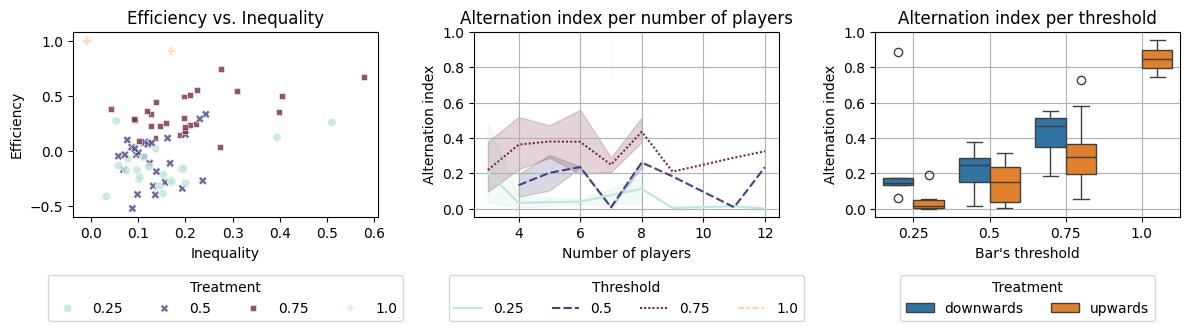

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(12,3), tight_layout=True)

# Scatter plot efficiency vs. inequality
df_jitter = df.copy()
n = df_jitter.shape[0]
df_jitter['inequality'] = df_jitter['inequality'] + np.random.normal(0,0.0075, n)
df_jitter['efficiency'] = df_jitter['efficiency'] + np.random.normal(0,0.0075, n)
sns.scatterplot(
    x='inequality', y='efficiency',
    data=df_jitter,
    hue='approx_threshold', style='approx_threshold',
    alpha=0.8, ax=ax[0],
    palette='icefire'
)

ax[0].set_xlabel('Inequality')
ax[0].set_ylabel('Efficiency')
ax[0].set_title('Efficiency vs. Inequality')
ax[0].legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -.6),
    ncol=4
)

# Alternation index per number of players
sns.lineplot(
    x='num_players', y='alternation index',
    hue='approx_threshold', style='approx_threshold',
    data=df, ax=ax[1],
    palette='icefire'
)
ax[1].set_xlabel("Number of players")
ax[1].set_ylabel("Alternation index")
ax[1].set_title("Alternation index per number of players")
ax[1].grid()
# ax[1].set_ylim([-1,1])
ax[1].legend(
    title='Threshold',
    loc='lower center', 
    bbox_to_anchor=(0.5, -.6),
    ncol=4
)

# Alternation index per treatment
sns.boxplot(
    x='approx_threshold', y='alternation index',
    hue='treatment',
    data=df, ax=ax[2]
)
ax[2].set_xlabel("Bar's threshold")
ax[2].set_ylabel("Alternation index")
ax[2].set_title("Alternation index per threshold")
ax[2].grid()
# ax[2].set_ylim([-1,1])
ax[2].legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -.6),
    ncol=2
)

### Alternation and efficiency

Text(0.5, 1.0, 'Treatment')

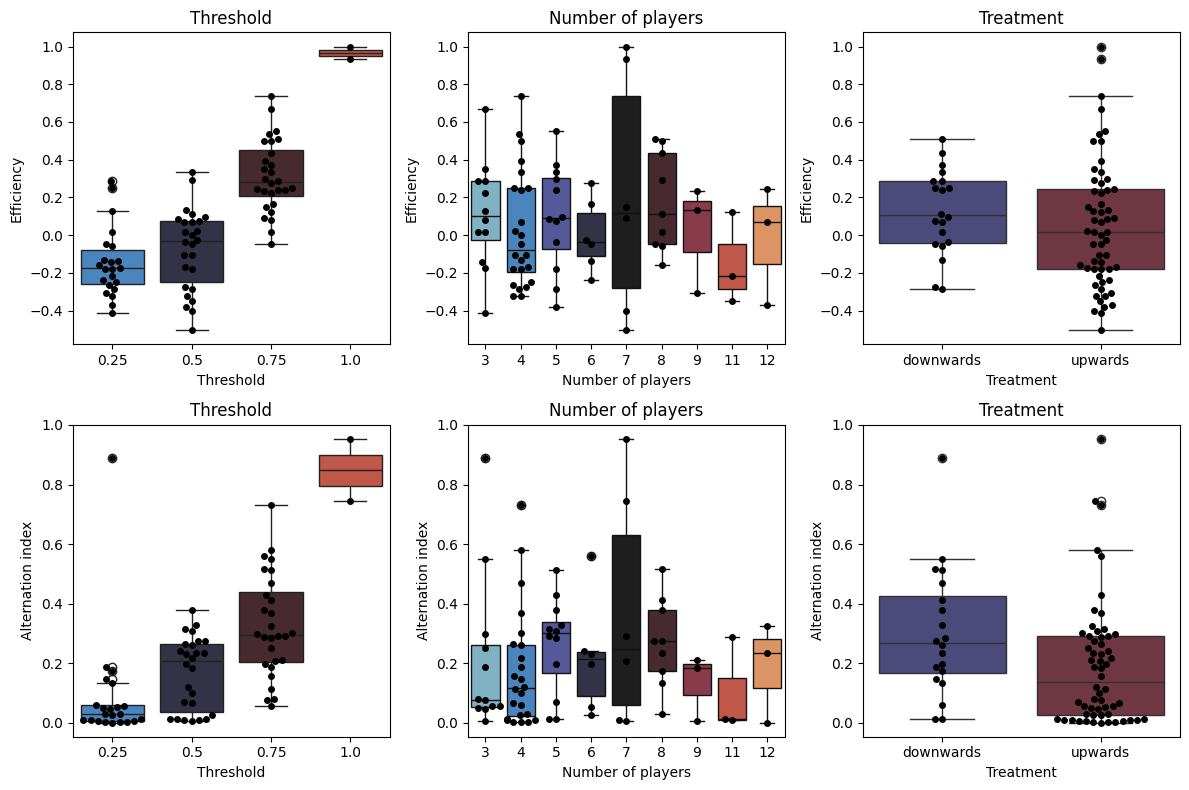

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(12,8), tight_layout=True)

# Distribution of efficiency per threshold
sns.boxplot(
    x='approx_threshold', y='efficiency',
    data=df, ax=ax[0, 0], palette='icefire'
)
sns.swarmplot(
    x='approx_threshold', y='efficiency',
    data=df, color='black', ax=ax[0, 0]
)
ax[0, 0].set_xlabel('Threshold')
ax[0, 0].set_ylabel('Efficiency')
ax[0, 0].set_title('Threshold')

# Distribution of efficiency per number of players
sns.boxplot(
    x='num_players', y='efficiency',
    data=df, ax=ax[0, 1], palette='icefire'
)
sns.swarmplot(
    x='num_players', y='efficiency',
    data=df, color='black', ax=ax[0, 1]
)
ax[0, 1].set_xlabel('Number of players')
ax[0, 1].set_ylabel('Efficiency')
ax[0, 1].set_title('Number of players')

# Distribution of efficiency per treatment
sns.boxplot(
    x='treatment', y='efficiency',
    data=df, ax=ax[0, 2], palette='icefire'
)
sns.swarmplot(
    x='treatment', y='efficiency',
    data=df, color='black', ax=ax[0, 2]
)
ax[0, 2].set_xlabel('Treatment')
ax[0, 2].set_ylabel('Efficiency')
ax[0, 2].set_title('Treatment')


# Distribution of alternation index per threshold
sns.boxplot(
    x='approx_threshold', y='alternation index',
    data=df, ax=ax[1, 0], palette='icefire'
)
sns.swarmplot(
    x='approx_threshold', y='alternation index',
    data=df, color='black', ax=ax[1, 0]
)
ax[1, 0].set_xlabel('Threshold')
ax[1, 0].set_ylabel('Alternation index')
ax[1, 0].set_title('Threshold')

# Distribution of alternation index per number of players
sns.boxplot(
    x='num_players', y='alternation index',
    data=df, ax=ax[1, 1], palette='icefire'
)
sns.swarmplot(
    x='num_players', y='alternation index',
    data=df, color='black', ax=ax[1, 1]
)
ax[1, 1].set_xlabel('Number of players')
ax[1, 1].set_ylabel('Alternation index')
ax[1, 1].set_title('Number of players')

# Distribution of alternation index per treatment
sns.boxplot(
    x='treatment', y='alternation index',
    data=df, ax=ax[1, 2], palette='icefire'
)
sns.swarmplot(
    x='treatment', y='alternation index',
    data=df, color='black', ax=ax[1, 2]
)
ax[1, 2].set_xlabel('Treatment')
ax[1, 2].set_ylabel('Alternation index')
ax[1, 2].set_title('Treatment')





fig, ax = plt.subplots(1, 1, figsize=(4,4), tight_layout=True)

# Scatter plot efficiency vs. inequality
df_jitter = df.copy()
n = df_jitter.shape[0]
df_jitter['inequality'] = df_jitter['inequality'] + np.random.normal(0,0.0075, n)
df_jitter['efficiency'] = df_jitter['efficiency'] + np.random.normal(0,0.0075, n)
sns.scatterplot(
    x='inequality', y='efficiency',
    data=df_jitter, hue='treatment', style='treatment',
    alpha=0.8, ax=ax,
    hue_order=['only score', 'score + grid'],
)

# Show the alternating groups on the top-left corner
circle = patches.Circle(
    (0.08, 0.92), 0.075, 
    transform=ax.transAxes, 
    color='gray', alpha=0.2, 
)
ax.add_patch(circle)
# Add an arrow pointing to the cluster
ax.annotate(
    'Alternating\n groups',
    xy=(0.15, 0.92), xycoords='axes fraction',
    xytext=(0.4, 0.9), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=8
)

# Show the alternating groups on the top-left corner
circle = patches.Circle((0.9, 0.875), 0.1, transform=ax.transAxes, 
                        color='gray', alpha=0.2)
ax.add_patch(circle)
# Add an arrow pointing to the cluster
ax.annotate(
    'Segmented\n   groups',
    xy=(0.9, 0.775), xycoords='axes fraction',
    xytext=(0.7, 0.2), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=8
)
ax.set_xlabel('Inequality')
ax.set_ylabel('Efficiency')
ax.set_title('Efficiency vs. Inequality')
ax.legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -.4),
    ncol=2
)


fig.savefig(PATHS['bar_images'] / 'eff_vs_ineq.png', dpi=300)